In [1]:
from google.colab import files
uploaded = files.upload()


Saving KDDTest+.txt to KDDTest+.txt
Saving KDDTrain+.txt to KDDTrain+.txt


In [22]:
pip install pandas numpy scikit-learn matplotlib seaborn


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)


In [24]:
# Load training and test data
train_df = pd.read_csv("KDDTrain+.txt", header=None)
test_df = pd.read_csv("KDDTest+.txt", header=None)

# Add column names
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
    'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty'
]
train_df.columns = columns
test_df.columns = columns


In [25]:
# Drop 'difficulty' column
train_df.drop('difficulty', axis=1, inplace=True)
test_df.drop('difficulty', axis=1, inplace=True)

# Combine train and test for consistent encoding
full_df = pd.concat([train_df, test_df], axis=0)

# Label encoding for categorical columns
cat_cols = ['protocol_type', 'service', 'flag']
le = LabelEncoder()
for col in cat_cols:
    full_df[col] = le.fit_transform(full_df[col])

# Binary encode target variable
full_df['label'] = full_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Split again into train and test
train_df = full_df.iloc[:len(train_df)]
test_df = full_df.iloc[len(train_df):]


In [26]:
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [27]:
rf_model = RandomForestClassifier(
    n_estimators=150,        # number of trees
    max_depth=None,          # let it expand fully
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1                # use all cores
)

rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42)

✅ Accuracy: 0.7712

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.97      0.79      9711
           1       0.97      0.62      0.76     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.80      0.77     22544
weighted avg       0.83      0.77      0.77     22544



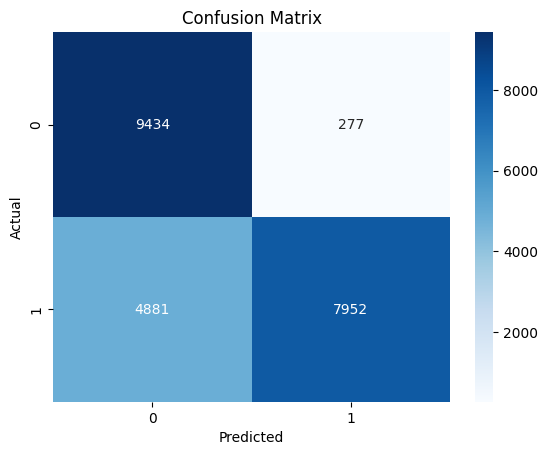

In [29]:
# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# Accuracy
acc = accuracy_score(y_test, y_pred_rf)
print(f"✅ Accuracy: {acc:.4f}")

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


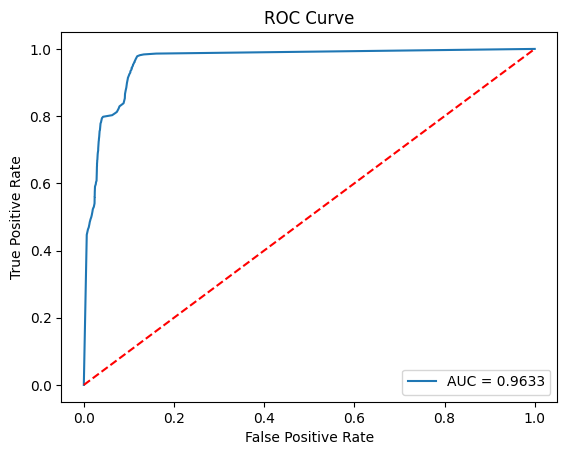

In [30]:
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


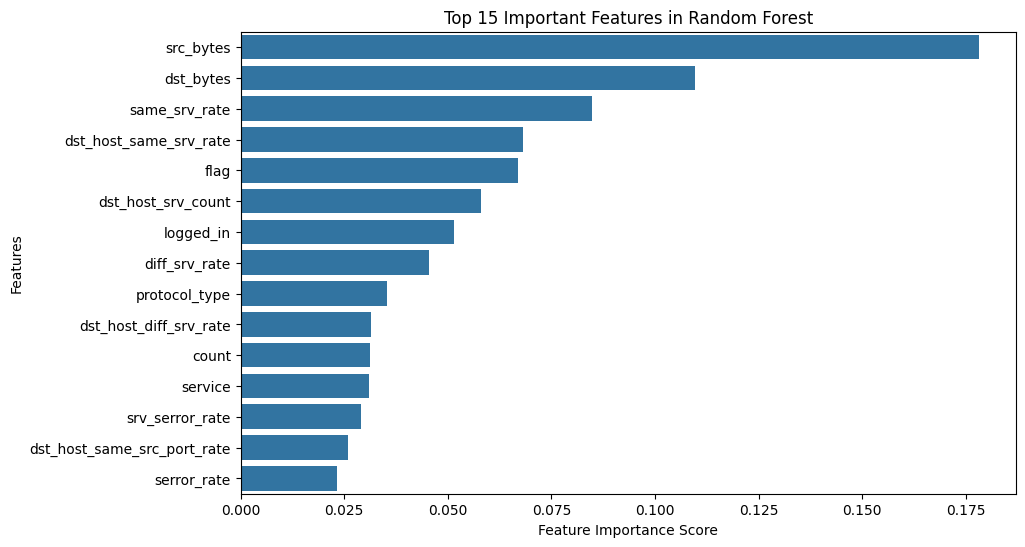

In [31]:
importances = rf_model.feature_importances_
feat_names = X_train.columns

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Top 15 Important Features in Random Forest")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()


In [32]:
import joblib
joblib.dump(rf_model, "random_forest_nslkdd_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [33]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define features and target (same as Random Forest part)
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

# Initialize XGBoost model with default settings
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xg = xgb_model.predict(X_test)

# Evaluate
print("Accuracy:", round(accuracy_score(y_test, y_pred_xg), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xg))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xg))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:22:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8009

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.97      0.81      9711
           1       0.97      0.67      0.79     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544


Confusion Matrix:
 [[9424  287]
 [4202 8631]]


In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define features and target (same as before)
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

# Initialize Decision Tree model with default settings
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate
print("Accuracy:", round(accuracy_score(y_test, y_pred_dt), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Accuracy: 0.7887

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544


Confusion Matrix:
 [[9421  290]
 [4473 8360]]


In [18]:
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Define features and target (same as before)
# X_train = train_df.drop('label', axis=1)
# y_train = train_df['label']
# X_test = test_df.drop('label', axis=1)
# y_test = test_df['label']

# # Initialize the SVM model with default parameters
# svm_model = SVC(random_state=42)

# # Train the model
# print("Training SVM... (this may take a while)")
# svm_model.fit(X_train, y_train)

# # Predictions
# y_pred = svm_model.predict(X_test)

# # Evaluate performance
# print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 4))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Training SVM... (this may take a while)

Accuracy: 0.4308

Classification Report:
               precision    recall  f1-score   support

           0       0.43      1.00      0.60      9711
           1       0.67      0.00      0.00     12833

    accuracy                           0.43     22544
   macro avg       0.55      0.50      0.30     22544
weighted avg       0.57      0.43      0.26     22544


Confusion Matrix:
 [[ 9710     1]
 [12831     2]]


In [19]:
# =========================
# Support Vector Machine (Optimized)
# =========================

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Optional: Use a subset for faster training (remove this part if you want full dataset)
# X_train_sub, y_train_sub = X_train[:15000], y_train[:15000]
# X_test_sub, y_test_sub = X_test[:5000], y_test[:5000]

# 1️⃣ Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2️⃣ Initialize the SVM with balanced class weights and linear kernel
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)

# 3️⃣ Train the model and measure time
start_time = time.time()
svm_model.fit(X_train_scaled, y_train)
end_time = time.time()

# 4️⃣ Make predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# 5️⃣ Evaluate results
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", round(accuracy, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nTraining Time:", round(end_time - start_time, 2), "seconds")


Accuracy: 0.7612

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.97      0.78      9711
           1       0.96      0.60      0.74     12833

    accuracy                           0.76     22544
   macro avg       0.81      0.79      0.76     22544
weighted avg       0.83      0.76      0.76     22544


Confusion Matrix:
 [[9416  295]
 [5088 7745]]

Training Time: 427.34 seconds


In [36]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# =========================
# Comparison Table
# =========================

# Calculate metrics for each model
models_results = {
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1-Score": f1_score(y_test, y_pred_rf)
    },
    "XGBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_xg),
        "Precision": precision_score(y_test, y_pred_xg),
        "Recall": recall_score(y_test, y_pred_xg),
        "F1-Score": f1_score(y_test, y_pred_xg)
    },
    "SVM (Optimized)": {
        "Accuracy": accuracy_score(y_test, y_pred_svm),
        "Precision": precision_score(y_test, y_pred_svm),
        "Recall": recall_score(y_test, y_pred_svm),
        "F1-Score": f1_score(y_test, y_pred_svm)
    },
    "Decision Tree": {
        "Accuracy": accuracy_score(y_test, y_pred_dt),
        "Precision": precision_score(y_test, y_pred_dt),
        "Recall": recall_score(y_test, y_pred_dt),
        "F1-Score": f1_score(y_test, y_pred_dt)
    }

}

# Convert to DataFrame
comparison_df = pd.DataFrame(models_results).T

# Round to 4 decimal places
comparison_df = comparison_df.round(4)

# Display the results
print("🔍 Model Comparison Table:")
display(comparison_df)


🔍 Model Comparison Table:


,Accuracy,Precision,Recall,F1-Score
Random Forest,0.7712,0.9663,0.6197,0.7551
XGBoost,0.8009,0.9678,0.6726,0.7936
SVM (Optimized),0.7612,0.9633,0.6035,0.7421
Decision Tree,0.7887,0.9665,0.6514,0.7783
